In [ ]:
import matplotlib.pyplot as plt
from ultralytics import YOLO
import cv2
import google.generativeai as genai
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import time
import os 
from projectaria_tools.core import data_provider, calibration
import projectaria_tools.core.mps as mps
from projectaria_tools.core import data_provider
from projectaria_tools.core.stream_id import StreamId
from projectaria_tools.core.mps.utils import (
    get_gaze_vector_reprojection,
    get_nearest_eye_gaze
)
import glob
from projectaria_tools.core.mps.utils import get_nearest_wrist_and_palm_pose
import pandas as pd



In [72]:
hw = pd.read_csv('/home/michaelrice/MichaelRiceThesis/sampledata/sample3/mps_Driving_Profile_Test_vrs/hand_tracking/wrist_and_palm_poses.csv')

hw = hw.drop(['nx_left_palm_device','ny_left_palm_device', 'nz_left_palm_device', 
              'nx_left_wrist_device', 'ny_left_wrist_device', 'nz_left_wrist_device',
              'nx_right_palm_device', 'ny_right_palm_device', 'nz_right_palm_device',
              'nx_right_wrist_device', 'ny_right_wrist_device', 'nz_right_wrist_device'], axis=1)

#save the data
hw.to_csv('/home/michaelrice/MichaelRiceThesis/sampledata/sample3/mps_Driving_Profile_Test_vrs/hand_tracking/wrist_and_palm_poses(2).csv', index=False)

## Helper Functions

In [ ]:


def rotate_one(frame):
    rotated = cv2.rotate(frame, cv2.ROTATE_90_CLOCKWISE)
    return rotated

def annotate_frames(frames_dir, timestamps, gaze_dir, wrist_and_palm_poses_path, output_dir):

    gaze_projections = []
    gaze_cpf = mps.read_eyegaze(gaze_dir)

    handwrist_points  = mps.hand_tracking.read_wrist_and_palm_poses(wrist_and_palm_poses_path)
    
    hand_tracking = {}

    for ts in timestamps:
        query_timestamp_ns = ts * 1e9

        eye_gaze_info = get_nearest_eye_gaze(gaze_cpf, query_timestamp_ns)
        wrist_and_palm_pose = get_nearest_wrist_and_palm_pose(handwrist_points, query_timestamp_ns)

        if wrist_and_palm_pose is not None:
            

            left_pose_confidence = wrist_and_palm_pose.left_hand.confidence
            left_wrist_position_device = wrist_and_palm_pose.left_hand.wrist_position_device
            left_palm_position_device = wrist_and_palm_pose.left_hand.palm_position_device
            left_wrist_normal_device = wrist_and_palm_pose.left_hand.wrist_and_palm_normal_device.wrist_normal_device
            left_palm_normal_device = wrist_and_palm_pose.left_hand.wrist_and_palm_normal_device.palm_normal_device

            # # Right-hand side
            right_pose_confidence = wrist_and_palm_pose.right_hand.confidence
            right_wrist_position_device = wrist_and_palm_pose.right_hand.wrist_position_device
            right_palm_position_device = wrist_and_palm_pose.right_hand.palm_position_device
            right_wrist_normal_device = wrist_and_palm_pose.right_hand.wrist_and_palm_normal_device.wrist_normal_device
            right_palm_normal_device = wrist_and_palm_pose.right_hand.wrist_and_palm_normal_device.palm_normal_device

            hand_tracking[ts] = {
                "left_pose_confidence": left_pose_confidence,
                "left_wrist_position_device": left_wrist_position_device,
                "left_palm_position_device": left_palm_position_device,
                "left_wrist_normal_device": left_wrist_normal_device,
                "left_palm_normal_device": left_palm_normal_device,
                "right_pose_confidence": right_pose_confidence,
                "right_wrist_position_device": right_wrist_position_device,
                "right_palm_position_device": right_palm_position_device,
                "right_wrist_normal_device": right_wrist_normal_device,
                "right_palm_normal_device": right_palm_normal_device
            }


        if eye_gaze_info:
            vrs_file = "/home/michaelrice/MichaelRiceThesis/sampledata/sample2/rgb_et.vrs"
            vrs_data_provider = data_provider.create_vrs_data_provider(vrs_file)

            rgb_stream_id = StreamId("214-1")
            rgb_stream_label = vrs_data_provider.get_label_from_stream_id(rgb_stream_id)
            device_calibration = vrs_data_provider.get_device_calibration()
            rgb_camera_calibration = device_calibration.get_camera_calib(rgb_stream_label)

            gaze_projection = get_gaze_vector_reprojection(
            eye_gaze_info,
            rgb_stream_label,
            device_calibration,
            rgb_camera_calibration,
            depth_m=eye_gaze_info.depth
        )
            
            gaze_projections.append(gaze_projection)

    frames = os.listdir(frames_dir)

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    
    for gp,ht, f in zip(gaze_projections,hand_tracking, frames):
        if '214-1' in f:
            frame = cv2.imread(os.path.join(frames_dir, f))
            rotated = cv2.rotate(frame, cv2.ROTATE_90_CLOCKWISE)

            np_frame = np.array(rotated)
            np_frame = cv2.circle(np_frame, (int(gp[0]), int(gp[1])), 9, (0, 0, 255), 3)

            # if wrist_and_palm_pose is not None:
            
                # lwp = (int(ht['left_wrist_position_device'].x), int(ht['left_wrist_position_device'].y))
                # lpp = (int(ht['left_palm_position_device'].x), int(ht['left_palm_position_device'].y))
                # rwp = (int(ht['right_wrist_position_device'].x), int(ht['right_wrist_position_device'].y))
                # rpp = (int(ht['right_palm_position_device'].x), int(ht['right_palm_position_device'].y))

                # np_frame = cv2.circle(np_frame, lwp, 5, (0, 255, 0), -1)
                # np_frame = cv2.circle(np_frame, lpp, 5, (0, 255, 0), -1)
                # np_frame = cv2.circle(np_frame, rwp, 5, (0, 255, 0), -1)
                # np_frame = cv2.circle(np_frame, rpp, 5, (0, 255, 0), -1)

                # np_frame = cv2.line(np_frame, lwp, lpp, (0, 255, 0), -1)
                # np_frame = cv2.line(np_frame, rwp, rpp, (0, 255, 0), -1)
            
            if not isinstance(np_frame, np.ndarray):
                raise ValueError("np_frame must be a NumPy array. instead got {}".format(type(np_frame)))


            cv2.imwrite(os.path.join(output_dir, f), np_frame)

    return gaze_projections, hand_tracking


def video_from_frames(frames_dir, output_dir, fps):
    frames = glob.glob(frames_dir + '/*.jpg')
    frames.sort()
    frame = cv2.imread(frames[0])
    height, width, layers = frame.shape
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    video = cv2.VideoWriter(output_dir, fourcc, fps, (width, height))

    for frame in frames:
        video.write(cv2.imread(frame))

    cv2.destroyAllWindows()
    video.release()

    



# VRS

### Command Line Stuff

### Sample 1

In [ ]:

vrs_timestamps = np.linspace(263.402, 276.002, 127)


gaze_points = annotate_and_save_gaze_frames('/home/michaelrice/MichaelRiceThesis/sampledata/sample2/rgb_frames', vrs_timestamps, 
                              '/home/michaelrice/MichaelRiceThesis/sampledata/sample2/general_eye_gaze.csv', '/home/michaelrice/MichaelRiceThesis/sampledata/sample2/gaze_frames' )



126


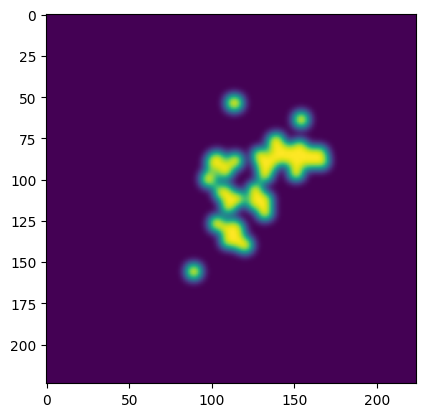

In [32]:
def gaze_to_heatmap(gaze_points, img_size=(224, 224)):
    heatmap = np.zeros(img_size)
    print(len(gaze_points))
    #normalise gaze points from original frame size of 1408x1408 to 224x224
    scale = (224/1408)
    gaze_points = [(x*scale, y*scale) for x, y in gaze_points]
    for x, y in gaze_points:
        heatmap = cv2.circle(heatmap, (int(x), int(y)), radius=5, color=1, thickness=-1)
    return cv2.GaussianBlur(heatmap, (15, 15), 0)

img = cv2.imread('/home/michaelrice/MichaelRiceThesis/sampledata/sample2/rgb_frames/214-1-00001-263.402.jpg')
heatmap = gaze_to_heatmap(gaze_points)
plt.imshow(heatmap)
plt.show()

In [54]:
video_from_frames('/home/michaelrice/MichaelRiceThesis/sampledata/sample2/gaze_frames', '/home/michaelrice/MichaelRiceThesis/sampledata/sample2/gaze_video.mp4', 10)

OpenCV: FFMPEG: tag 0x44495658/'XVID' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


In [17]:

#undo distortion
from projectaria_tools.core import data_provider, calibration

# Create an instance of data_provider
vrs_file = "/home/michaelrice/MichaelRiceThesis/sampledata/sample1/rgbsample1.vrs"
provider = data_provider.create_vrs_data_provider(vrs_file)

camera_label = "camera-rgb"
stream_id = provider.get_stream_id_from_label(camera_label)

calib = provider.get_device_calibration().get_camera_calib(camera_label)
pinhole = calibration.get_linear_camera_calibration(512, 512, 150)

raw_image = provider.get_image_data_by_index(stream_id, 0)[0].to_numpy_array()
undistorted_image = calibration.distort_by_calibration(raw_image, pinhole, calib)


[MultiRecordFileReader][DEBUG]: Opened file '/home/michaelrice/MichaelRiceThesis/sampledata/sample1/rgbsample1.vrs' and assigned to reader #0
[VrsDataProvider][INFO]: streamId 214-1/camera-rgb activated


In [19]:
from projectaria_tools.core.calibration import (
    device_calibration_from_json_string,
    distort_by_calibration,
    get_linear_camera_calibration,
)



with open('/home/michaelrice/MichaelRiceThesis/Coding/calibration.json') as f:
    sensors_calib_json = f.read()

sensors_calib = device_calibration_from_json_string(sensors_calib_json)
rgb_calib = sensors_calib.get_camera_calib("camera-rgb")
dst_calib = get_linear_camera_calibration(512, 512, 150, "camera-rgb")


for file in os.listdir('/home/michaelrice/MichaelRiceThesis/sampledata/sample2/gaze_frames'):

    img = cv2.imread('/home/michaelrice/MichaelRiceThesis/sampledata/sample2/gaze_frames/' + file)

    undistorted_rgb_image = distort_by_calibration(
                    img, dst_calib, rgb_calib
                )
    cv2.imwrite('/home/michaelrice/MichaelRiceThesis/sampledata/sample2/undist_gaze_frames/' + file, undistorted_rgb_image)	



In [22]:
video_from_frames('/home/michaelrice/MichaelRiceThesis/sampledata/sample2/undist_gaze_frames', '/home/michaelrice/MichaelRiceThesis/sampledata/sample2/undist_gaze_video.mp4', 10)

OpenCV: FFMPEG: tag 0x44495658/'XVID' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


### Driving Stuff

### Sample 3

In [17]:
!vrs /home/michaelrice/MichaelRiceThesis/sampledata/sample3/Driving_Profile_Test.vrs 


[ProgressLogger][INFO]: 2025-03-10 18:24:39: Opening /home/michaelrice/MichaelRiceThesis/sampledata/sample3/Driving_Profile_Test.vrs...
[VRSIndexRecord][WARNING]: 2 record(s) not sorted properly. Sorting index.
VRS file: '/home/michaelrice/MichaelRiceThesis/sampledata/sample3/Driving_Profile_Test.vrs', 127 MiB.
Found 11 streams, 32129 records, 32107 data records from 119.491 to 136.777 (17.286s, 1857rps).
  Tag: calib_json = {"AlgorithmName":"ArianeEtExtrinsicsMirrorStationCalibration","AlgorithmVersion":"<No HG commit hash available - Buck build>","BaroCalibrations":[{"Label":"baro0","PressureModel":{"Name":"Linear","OffsetPa":-65.00879999999999,"Slope":0.9998},"SerialNumber":""}],"CalibrationSource":"Factory","CameraCalibrations":[{"Calibrated":true,"Label":"camera-slam-left","Projection":{"Description":"see FisheyeRadTanThinPrism.h","Name":"FisheyeRadTanThinPrism","Params":[242.3392309760843,318.0334554305309,238.8906200309433,-0.02720848805309562,0.1050418109028592,-0.0764307754688

In [32]:
!vrs extract-images /home/michaelrice/MichaelRiceThesis/sampledata/sample3/Driving_Profile_Test.vrs --to /home/michaelrice/MichaelRiceThesis/sampledata/sample3/frames 

[ProgressLogger][INFO]: 2025-03-10 18:47:55: Opening /home/michaelrice/MichaelRiceThesis/sampledata/sample3/Driving_Profile_Test.vrs...
[VRSIndexRecord][WARNING]: 2 record(s) not sorted properly. Sorting index.
Writing /home/michaelrice/MichaelRiceThesis/sampledata/sample3/frames/214-1-00001-119.521.jpg
Writing /home/michaelrice/MichaelRiceThesis/sampledata/sample3/frames/1201-2-00001-119.521.jpg
Writing /home/michaelrice/MichaelRiceThesis/sampledata/sample3/frames/1201-1-00001-119.521.jpg
Writing /home/michaelrice/MichaelRiceThesis/sampledata/sample3/frames/211-1-00001-119.521.jpg
Writing /home/michaelrice/MichaelRiceThesis/sampledata/sample3/frames/214-1-00002-119.571.jpg
Writing /home/michaelrice/MichaelRiceThesis/sampledata/sample3/frames/214-1-00003-119.621.jpg
Writing /home/michaelrice/MichaelRiceThesis/sampledata/sample3/frames/1201-2-00002-119.621.jpg
Writing /home/michaelrice/MichaelRiceThesis/sampledata/sample3/frames/1201-1-00002-119.621.jpg
Writing /home/michaelrice/Michael

In [105]:
timestamps = np.linspace(119.521, 136.771, 346)

gaze_points = annotate_frames('/home/michaelrice/MichaelRiceThesis/sampledata/sample3/frames', timestamps,
                              '/home/michaelrice/MichaelRiceThesis/sampledata/sample3/mps_Driving_Profile_Test_vrs/eye_gaze/general_eye_gaze.csv',
                              '/home/michaelrice/MichaelRiceThesis/sampledata/sample3/mps_Driving_Profile_Test_vrs/hand_tracking/wrist_and_palm_poses(2).csv', 
                              '/home/michaelrice/MichaelRiceThesis/sampledata/sample3/gaze_frames' )

Loaded #EyeGazes: 173
Loaded #WristAndPalmPose: 172


AttributeError: '_core_pybinds.mps.hand_tracking.WristAndPalmPose.OneSide' object has no attribute 'wrist_and_palm_normal_device'